This project aims to predict whether a customer is likely to return and make repeat purchases at Walmart based on their demographic details and purchase behavior. By analyzing historical purchase data, we use machine learning techniques to build a classification model that identifies repeat customers. This helps the business better understand customer loyalty, improve marketing strategies, and enhance overall customer retention.

# **Step 1: Import Necessary Libraries**


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Step 2: Load the Dataset

In [42]:
df=pd.read_csv('/content/Walmart_customer_purchases.csv')

A. Understand the data

In [43]:
df.head()

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,No,1,Yes
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,Yes,1,No
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,Yes,1,No
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,No,2,Yes
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,Yes,2,Yes


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Customer_ID       50000 non-null  object 
 1   Age               50000 non-null  int64  
 2   Gender            50000 non-null  object 
 3   City              50000 non-null  object 
 4   Category          50000 non-null  object 
 5   Product_Name      50000 non-null  object 
 6   Purchase_Date     50000 non-null  object 
 7   Purchase_Amount   50000 non-null  float64
 8   Payment_Method    50000 non-null  object 
 9   Discount_Applied  50000 non-null  object 
 10  Rating            50000 non-null  int64  
 11  Repeat_Customer   50000 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 4.6+ MB


In [45]:
df.describe()

,Age,Purchase_Amount,Rating
count,50000.000000,50000.000000,50000.000000
mean,38.945220,255.532230,2.998680
std,12.398137,141.574416,1.417956
min,18.000000,10.010000,1.000000
25%,28.000000,133.050000,2.000000
50%,39.000000,255.045000,3.000000
75%,50.000000,378.912500,4.000000
max,60.000000,499.990000,5.000000


# Step 3: Data Cleaning & Preprocessing

A. Handle Missing Values

In [46]:
# Convert the Purchase_Date column to datetime
df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')

In [47]:
df.shape

(50000, 12)

In [48]:
#null values
print('Missing values by column:')
print(df.isnull().sum())

Missing values by column:
Customer_ID         0
Age                 0
Gender              0
City                0
Category            0
Product_Name        0
Purchase_Date       0
Purchase_Amount     0
Payment_Method      0
Discount_Applied    0
Rating              0
Repeat_Customer     0
dtype: int64


In [49]:
# Drop rows with missing Purchase_Date if any, as it is important for time based analysis
df = df.dropna(subset=['Purchase_Date'])

In [50]:
# For simplicity, fill missing values in other columns with appropriate defaults if necessary
for col in ['Age', 'Purchase_Amount', 'Rating']:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].median(), inplace=True)

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Purchase_Date'}>],
       [<Axes: title={'center': 'Purchase_Amount'}>,
        <Axes: title={'center': 'Rating'}>]], dtype=object)

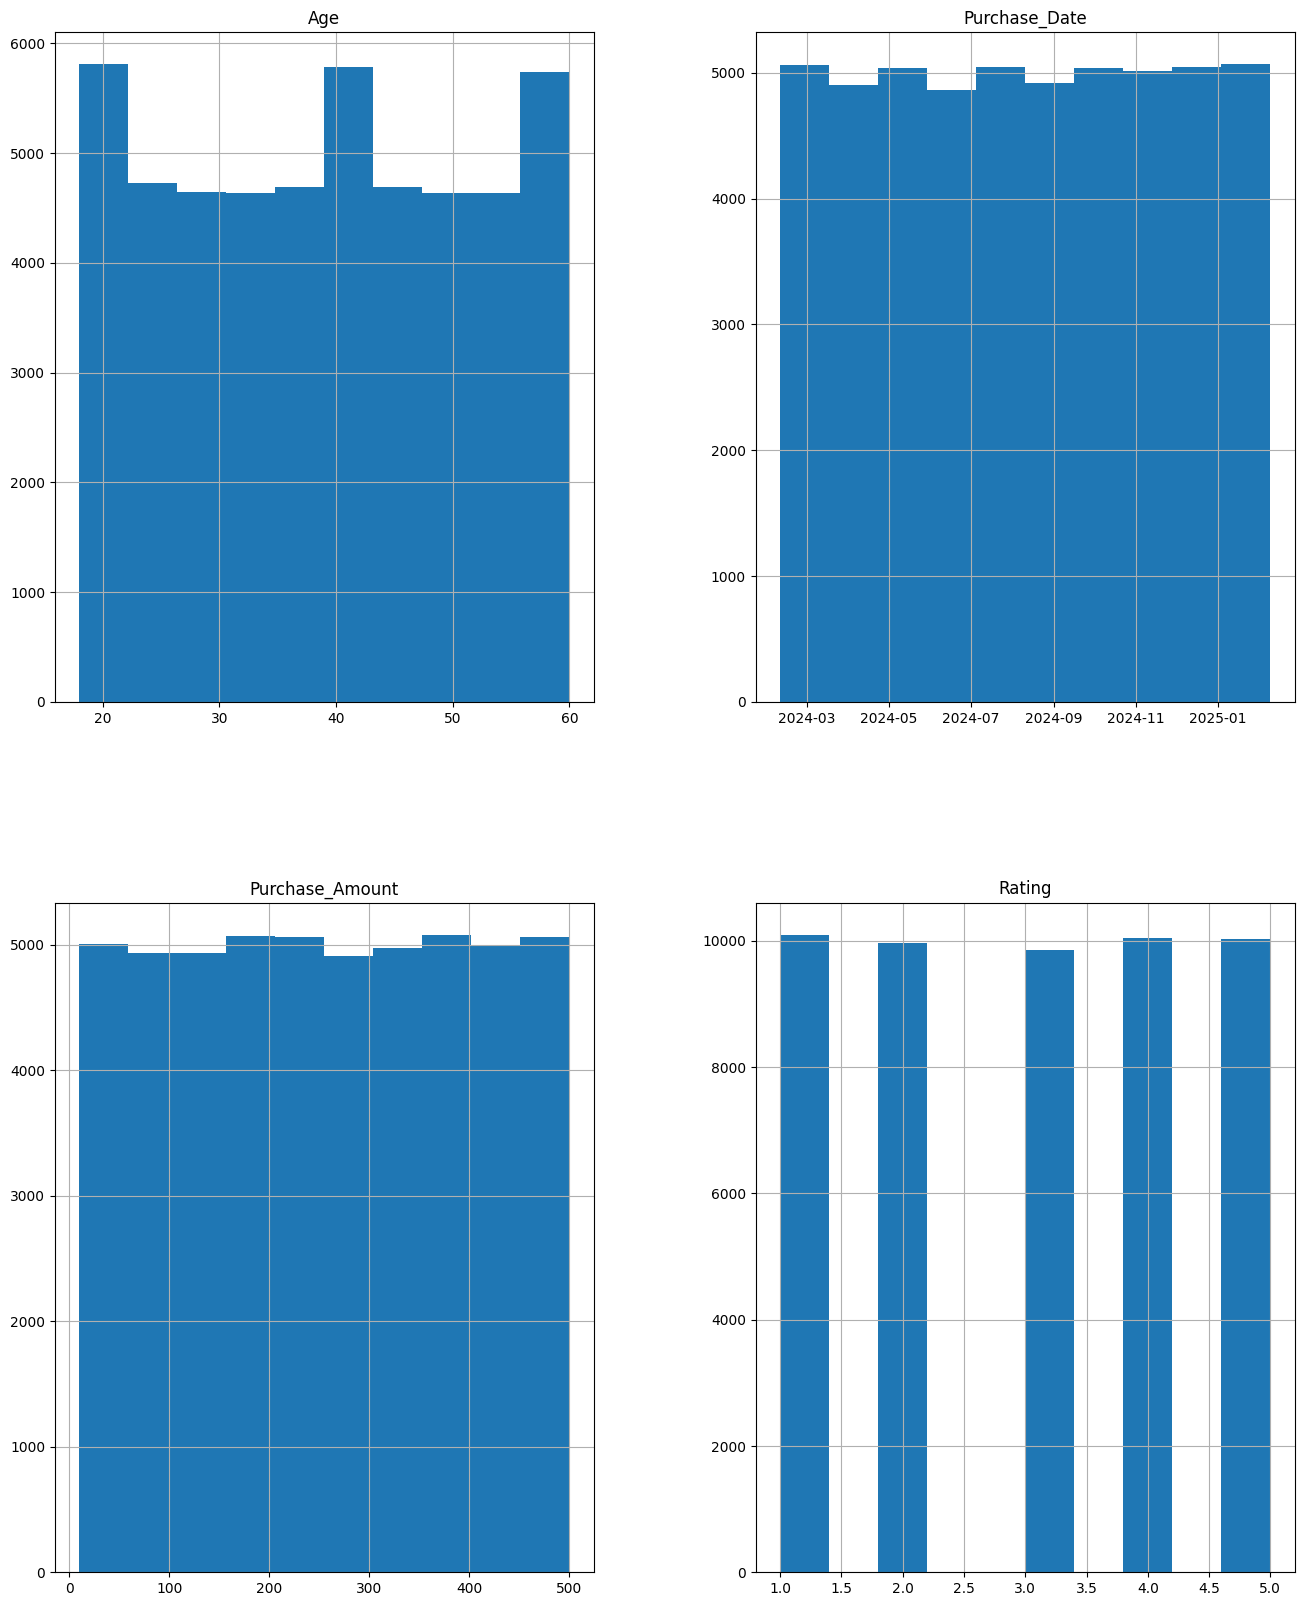

In [51]:
df.hist(figsize=(16,20))

In [52]:
# Step 1: Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# Step 2: Calculate skewness
skewness = numeric_df.skew()
skewed_features = skewness[abs(skewness) > 0.5].index  # Only skewed ones

print("Skewed features to transform:\n", list(skewed_features))

# Step 3: Apply log1p (log(x+1)) transformation only to non-negative features
log_data = numeric_df.copy()
for col in skewed_features:
    if (log_data[col] >= 0).all():
        log_data[col] = np.log1p(log_data[col])  # log1p = log(x + 1)
        print(f"Log1p transformed: {col}")

# Optional: Replace in original df if needed
# df[skewed_features] = log_data[skewed_features]

# Step 4: Plot histograms of transformed features
num_features = len(skewed_features)
plt.figure(figsize=(5 * num_features, 4))

for i, column in enumerate(skewed_features, 1):
    plt.subplot(1, num_features, i)
    sns.histplot(log_data[column], bins=30, kde=True)
    plt.title(f"{column}\nSkew: {log_data[column].skew():.2f}")

plt.tight_layout()
plt.show()

Skewed features to transform:
 []


<Figure size 0x400 with 0 Axes>

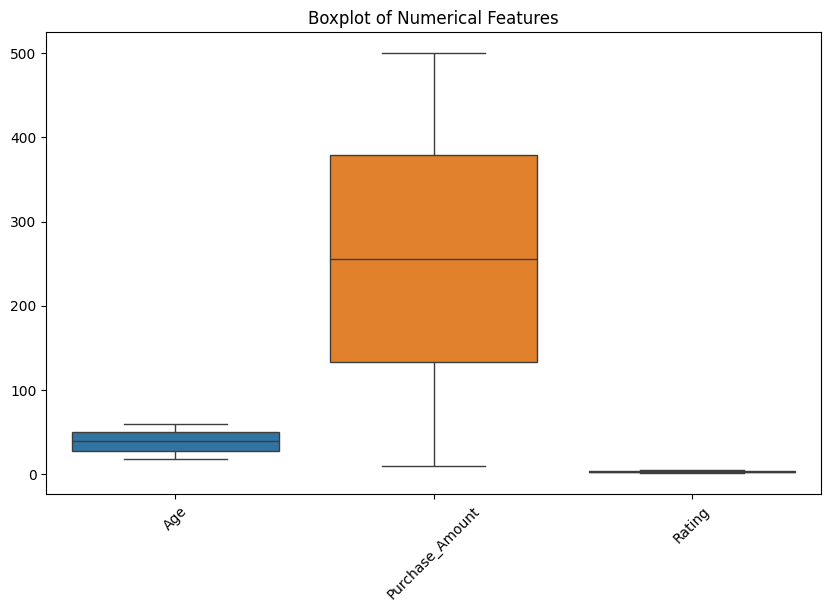

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df.select_dtypes(include='number'))
plt.xticks(rotation=45)
plt.title('Boxplot of Numerical Features')
plt.show()

In [54]:
 #IQR method to detect outliers
def detect_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower) | (data[column] > upper)]
    return outliers

In [55]:
# Example: Apply to one or more columns
for col in df.select_dtypes(include='number').columns:
    outliers = detect_outliers_iqr(df, col)
    print(f'{col} - Number of outliers: {len(outliers)}')

Age - Number of outliers: 0
Purchase_Amount - Number of outliers: 0
Rating - Number of outliers: 0


# **Step 4: Exploratory Data Analysis (EDA)**

In [56]:
df.dtypes

,0
Customer_ID,object
Age,int64
Gender,object
City,object
Category,object
Product_Name,object
Purchase_Date,datetime64[ns]
Purchase_Amount,float64
Payment_Method,object
Discount_Applied,object



A. Create Target Variable (Repeat_Customer)
Convert Repeat_Customer (Yes/No) to binary.

In [57]:
# Prepare data for modeling
from sklearn.preprocessing import LabelEncoder

# Assume that 'Repeat_Customer' has values like 'Yes' and 'No', convert them to binary
df['Repeat_Customer_Flag'] = df['Repeat_Customer'].map(lambda x: 1 if x.lower() == 'yes' else 0)

# Select features for the model; we'll use a mix of numeric and encoded categorical features
features = ['Age', 'Purchase_Amount', 'Rating']

# Encode 'Gender' and 'Payment_Method' as they are likely to affect purchase behavior
for col in ['Gender', 'Payment_Method']:
    le = LabelEncoder()
    df[col + '_Encoded'] = le.fit_transform(df[col])
    features.append(col + '_Encoded')

In [58]:
df

,Customer_ID,Age,Gender,City,Category,Product_Name,Purchase_Date,Purchase_Amount,Payment_Method,Discount_Applied,Rating,Repeat_Customer,Repeat_Customer_Flag,Gender_Encoded,Payment_Method_Encoded
0,84607c1f-910c-44d5-b89f-e1ee06dd34c0,49,Female,New Cynthia,Electronics,Smartphone,2024-08-30,253.26,Cash on Delivery,No,1,Yes,1,0,0
1,f2a81712-a73e-4424-8b39-4c615a0bd4ea,36,Other,Cruzport,Clothing,T-Shirt,2024-12-21,73.19,Debit Card,Yes,1,No,0,2,2
2,da9be287-8b0e-4688-bccd-1a2cdd7567c6,52,Male,Jeffreytown,Beauty,Perfume,2024-12-26,125.62,Credit Card,Yes,1,No,0,1,1
3,50ec6932-3ac7-492f-9e55-4b148212f302,47,Female,Jenniferburgh,Electronics,Smartwatch,2024-11-04,450.32,Credit Card,No,2,Yes,1,0,1
4,8fdc3098-fc75-4b0f-983c-d8d8168c6362,43,Other,Kingshire,Electronics,Smartphone,2024-10-07,369.28,Credit Card,Yes,2,Yes,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,80853da9-ef96-4c83-9191-bc872c3968a9,48,Male,Barbaramouth,Electronics,Laptop,2024-11-18,391.48,Debit Card,No,5,No,0,1,2
49996,97df1ed3-4041-474c-8ce8-958c816fc30a,51,Female,Troyshire,Beauty,Perfume,2024-11-19,272.09,Cash on Delivery,Yes,1,No,0,0,0
49997,948efe87-82a3-4a38-9dd6-30d44ad6f879,51,Male,South Rachel,Home,Curtains,2024-02-11,280.81,Debit Card,Yes,2,No,0,1,2
49998,9804d52f-35cd-4af3-a9e3-cbb8367396f0,33,Other,Courtneyville,Beauty,Shampoo,2024-08-31,140.74,Debit Card,No,2,No,0,2,2


# **Step 6: Train-Test Split**

In [59]:
# For simplicity, we'll ignore high cardinality columns such as Customer_ID, City, Product_Name, etc.

X = df[features]
y = df['Repeat_Customer_Flag']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# **Step 7: Train the Random Forest Model**

In [60]:

# Initialize Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict on test set
y_pred = clf.predict(X_test)

# **Step 8: Evaluate the Model**

A. Accuracy

In [61]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of the Random Forest Classifier:', accuracy)

Accuracy of the Random Forest Classifier: 0.5016666666666667


B. Confusion Matrix

In [62]:
# classification models and metrics

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer  # Import SimpleImputer for handling NaNs
import pandas as pd # import pandas


# Assuming 'Attrition' is your target variable
X = df.drop('Repeat_Customer_Flag', axis=1)
y = df['Repeat_Customer_Flag']

# Select only numeric features for imputation
numeric_features = X.select_dtypes(include=np.number).columns
X_numeric = X[numeric_features]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# Impute missing values using SimpleImputer (replace NaNs with the mean of the column)
imputer = SimpleImputer(strategy='mean')  # You can change the strategy if needed
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Convert the imputed NumPy arrays back to DataFrames with original column names
X_train = pd.DataFrame(X_train, columns=numeric_features, index=y_train.index)
X_test = pd.DataFrame(X_test, columns=numeric_features, index=y_test.index)


# Initialize and train the models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

results = {}
for model_name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_pred)

  results[model_name] = {
      "Accuracy": accuracy,
      "Precision": precision,
      "Recall": recall,
      "F1-Score": f1,
      "ROC AUC": roc_auc
  }

  print(f"Model: {model_name}")
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))
  print("-" * 30)

# Display results in a table or as needed
for model_name, metrics in results.items():
    print(f"{model_name}:")
    for metric_name, value in metrics.items():
        print(f"  {metric_name}: {value:.4f}")
    print("-" * 30)

Model: Logistic Regression
              precision    recall  f1-score   support

           0       0.47      0.12      0.19      4989
           1       0.50      0.87      0.63      5011

    accuracy                           0.49     10000
   macro avg       0.48      0.49      0.41     10000
weighted avg       0.48      0.49      0.41     10000

[[ 599 4390]
 [ 673 4338]]
------------------------------
Model: Random Forest
              precision    recall  f1-score   support

           0       0.51      0.51      0.51      4989
           1       0.51      0.51      0.51      5011

    accuracy                           0.51     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.51      0.51      0.51     10000

[[2522 2467]
 [2443 2568]]
------------------------------
Model: Decision Tree
              precision    recall  f1-score   support

           0       0.50      0.50      0.50      4989
           1       0.51      0.51      0.51      501

In [63]:
# # Generate and plot the confusion matrix
# cm = confusion_matrix(y_test, y_pred)
# plt.figure()
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()



C. ROC Curve

In [64]:
# # ROC Curve
# y_proba = clf.predict_proba(X_test)[:, 1]
# fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()